In [142]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import datetime
import re

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Задание

С помощью генерации признаков получить rmse меньше 5000 на тестовой части выборки.

Постарайтесь получить такой результат сначала с помощью **RandomForestRegressor**, а затем и с помощью **Ridge**.

Если с помощью признаков меньше 5000 не получается, можно попробовать улучшить результат с помощью обучения других моделей, подбора параметров и усреднения предсказаний разных моделей.

Для генерации признаков вам сможет помочь код из последнего семинара.

# предобработаем данные

In [162]:
data = pd.read_csv('MotorcycleData.csv', encoding='cp1252', sep=',', )
data.drop('Unnamed: 0', axis=1, inplace=True)

# print(data.head(2))

f = lambda x: re.sub('[,$]', '', x)
data.Price = data.Price.map(f).astype(int)


data.head(5)

,Condition,Condition_Desc,Price,Location,Model_Year,Mileage,Exterior_Color,Make,Warranty,Model,...,Vehicle_Title,OBO,Feedback_Perc,Watch_Count,N_Reviews,Seller_Status,Vehicle_Tile,Auction,Buy_Now,Bid_Count
0,Used,mint!!! very low miles,11412,"McHenry, Illinois, United States",2013.0,"16,000",Black,Harley-Davidson,Unspecified,Touring,...,NaN,False,8.1,NaN,2427,Private Seller,Clear,True,False,28.0
1,Used,Perfect condition,17200,"Fort Recovery, Ohio, United States",2016.0,60,Black,Harley-Davidson,Vehicle has an existing warranty,Touring,...,NaN,False,100,17,657,Private Seller,Clear,True,True,0.0
2,Used,NaN,3872,"Chicago, Illinois, United States",1970.0,"25,763",Silver/Blue,BMW,Vehicle does NOT have an existing warranty,R-Series,...,NaN,False,100,NaN,136,NaN,Clear,True,False,26.0
3,Used,CLEAN TITLE READY TO RIDE HOME,6575,"Green Bay, Wisconsin, United States",2009.0,"33,142",Red,Harley-Davidson,NaN,Touring,...,NaN,False,100,NaN,2920,Dealer,Clear,True,False,11.0
4,Used,NaN,10000,"West Bend, Wisconsin, United States",2012.0,"17,800",Blue,Harley-Davidson,NO WARRANTY,Touring,...,NaN,False,100,13,271,OWNER,Clear,True,True,0.0


# разобьем их на трейн и тест

часть выборки мы сохраним и будем использовать как тестовую выборку

In [163]:
target = 'Price'

skf = KFold(shuffle=True, random_state=0)
for itr, ite in skf.split(data):
    break

y_train = data.loc[itr, target].values
y_test = data.loc[ite, target].values
data.loc[ite, target] = np.nan
data.drop(['Price'], axis=1, inplace=True)



print(len(itr), len(ite))
# data.describe()
data.describe(include=['O'])

4995 2498


,Condition,Condition_Desc,Location,Mileage,Exterior_Color,Make,Warranty,Model,Sub_Model,Type,Feedback_Perc,Watch_Count,Seller_Status,Vehicle_Tile
count,7493,1656,7491,7471,6778,7489,5107,7434,2179,6257,6785,3278,6861,7439
unique,2,1184,2026,3985,869,59,70,1750,1207,230,63,76,29,4
top,Used,Excellent condition,"Suncook, New Hampshire, United States",0,Black,Harley-Davidson,Vehicle does NOT have an existing warranty,Touring,FINANCING AVAILABLE - 704-824-8533,Gasoline,100,1<,Dealer,Clear
freq,6564,20,392,547,1833,2955,2624,805,20,1619,5723,520,3753,7159


In [ ]:
#Алгоритм
# 1. Посмотреть на корреляцию признаков
#    1.1 Возможно удалить некоторые столбцы
#    1.2 Определить и натренировать отдельно некоторые столбцы
#    1.3 Заменить текстовые на числовые (столбцы: Condition, Condition_desc, Feedback, Extrior_Color, Make, Warranty, Type)
# 2. Посчитать на среднее, матожидание по столбцам
# 3. Все пропущенные значения признаков заполнить нулями или средними значениями
# 4. Протестировать на разных алгоритмах

In [164]:
# Deleted 
# Аукцион отрицательно влияет практически на все признаки - можно и удалить


data.drop(['Feedback_Perc'], axis=1, inplace=True)
data.head(10)

,Condition,Condition_Desc,Location,Model_Year,Mileage,Exterior_Color,Make,Warranty,Model,Sub_Model,Type,Vehicle_Title,OBO,Watch_Count,N_Reviews,Seller_Status,Vehicle_Tile,Auction,Buy_Now,Bid_Count
0,Used,mint!!! very low miles,"McHenry, Illinois, United States",2013.0,"16,000",Black,Harley-Davidson,Unspecified,Touring,street glide custom,Cruiser,NaN,False,NaN,2427,Private Seller,Clear,True,False,28.0
1,Used,Perfect condition,"Fort Recovery, Ohio, United States",2016.0,60,Black,Harley-Davidson,Vehicle has an existing warranty,Touring,Street Glide,Sport Touring,NaN,False,17,657,Private Seller,Clear,True,True,0.0
2,Used,NaN,"Chicago, Illinois, United States",1970.0,"25,763",Silver/Blue,BMW,Vehicle does NOT have an existing warranty,R-Series,R75/5 SWB,Standard,NaN,False,NaN,136,NaN,Clear,True,False,26.0
3,Used,CLEAN TITLE READY TO RIDE HOME,"Green Bay, Wisconsin, United States",2009.0,"33,142",Red,Harley-Davidson,NaN,Touring,ultra classic,Touring,NaN,False,NaN,2920,Dealer,Clear,True,False,11.0
4,Used,NaN,"West Bend, Wisconsin, United States",2012.0,"17,800",Blue,Harley-Davidson,NO WARRANTY,Touring,STREET GLIDE,Touring,NaN,False,13,271,OWNER,Clear,True,True,0.0
5,Used,It&#039;s a &#039;72 in good shape,"Watervliet, Michigan, United States",1972.0,0,Red,Harley-Davidson,Vehicle does NOT have an existing warranty,Sportster,NaN,NaN,NaN,False,NaN,412,Private Seller,Clear,True,False,1.0
6,Used,NaN,"Sterling, Illinois, United States",2010.0,"5,548",Grey / Red / Silver Metallic,Harley-Davidson,NaN,Touring,GATOR GLASS PAINT,Touring,NaN,False,NaN,6229,Dealer,Clear,True,False,1.0
7,Used,NaN,"Williamston, Michigan, United States",1975.0,"17,868",Black,Harley-Davidson,Vehicle does NOT have an existing warranty,Sportster,XLH,Sportster,NaN,False,NaN,1159,Private Seller,Clear,True,False,6.0
8,Used,NaN,"Palatine, Illinois, United States",2014.0,"2,800",Cherry Red,Harley-Davidson,Vehicle does NOT have an existing warranty,Touring,NaN,Touring,NaN,False,16,3,Private Seller,Clear,True,True,6.0
9,Used,NaN,"Chicago, Illinois, United States",2015.0,"3,000",Black,Harley-Davidson,Vehicle has an existing warranty,Sportster,Forty Eight,Cruiser,NaN,False,NaN,1,Private Seller,Clear,True,False,0.0


In [165]:

def searchfunction(pattern, series, colname):
    
    print(series.shape)
    for i, v in series.iteritems():
#         print(i, v)
        if (re.search(pattern, str(v))):
            v = pattern
            data.at[i, colname] = str(pattern)
        
    

## Seller_Status

In [166]:
#===Seller

#Надо one-hot encoding
data['Seller_Status'] = data['Seller_Status'].str.lower()
data['Seller_Status']  = data['Seller_Status'].fillna("none") #Потом исправить
data.groupby(['Seller_Status'])['Seller_Status'].count()

Seller_Status
220000                                                1
belvidere police department                           1
bikesfordutch                                         1
by owner                                              2
carrigan motor group                                  5
customs by barry, 40+ years successful building       1
dealer                                             3753
factory                                               1
first owner                                           2
johnny ray richland    trike on america               5
manufacturer                                          1
none                                                632
onwer                                                 1
original owner                                        4
original owners son                                   1
owner                                               184
pawnbroker                                            1
peter root                        

In [167]:
# parsedData = data.groupby(['Seller_Status'])['Seller_Status'].count()
# print(parsedData.index)
# parsedData = pd.DataFrame({'Seller_Status': parsedData.index, 'Count':parsedData.values})
searchfunction(r'owner', data['Seller_Status'], 'Seller_Status')
searchfunction(r'private', data['Seller_Status'], 'Seller_Status')


data['Seller_Status'] = data['Seller_Status'].replace(['220000', 'bikesfordutch', 'belvidere police department', 'factory', 'manufacturer', 'pawnbroker', 'peter root', 'ricky'], 'private')
data['Seller_Status'] = data['Seller_Status'].replace(['carrigan motor group', 'customs by barry, 40+ years successful building', 'johnny ray richland    trike on america', 'shoreline harley -  davidson', 'wholesale'], 'dealer')
data['Seller_Status'] = data['Seller_Status'].replace(['onwer'], 'owner')



print(data.groupby(['Seller_Status'])['Seller_Status'].count())
print(data.Seller_Status.value_counts())
#Заполнить нули none чем-то
data['Seller_Status'] = data['Seller_Status'].map({'dealer': 1, 'owner': 2, 'private':3, 'none':0})

(7493,)
(7493,)
Seller_Status
dealer     3766
none        632
owner       196
private    2899
Name: Seller_Status, dtype: int64
dealer     3766
private    2899
none        632
owner       196
Name: Seller_Status, dtype: int64


## Model_Year

In [168]:
#удаляем nan Значения

print(data[data['Model_Year'].isnull()].any(axis=1))
# print("1=", data.ix[5268])
# data = data[np.notnull(data['Model_Year'])]
data = data.dropna(subset=['Model_Year'])
# print("2=", data.ix[5268])

data['Model_Year'] = data['Model_Year']*1.0

5268    True
6144    True
6164    True
6184    True
dtype: bool


2018.0


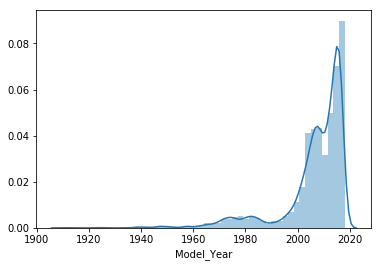

In [108]:
# Take a further look at Age
print(data['Model_Year'].max())
sns.distplot(data['Model_Year'])

## MileAge

In [169]:
def ddd(x):
    print(x)
    return re.sub(',', '', x)

In [170]:
# data['Mileage'] = data['Mileage'].fillna(-1)


print(data[data['Mileage'].isnull()].any(axis=1))

# print(data['Mileage'][1602])
# print(data['Mileage'])

data['Mileage'] = data['Mileage'].replace('N/A',np.NaN)
data['Mileage'] = data['Mileage'].replace('n/a',np.NaN)
data['Mileage'] = data['Mileage'].replace('Na',np.NaN)

data['Mileage'] = data['Mileage'].fillna("-1")

# print(data['Mileage'][1602])


data['Mileage'] = data['Mileage'].map(ddd).astype(int)


#Осталось заменить значения меньше на значения медиан (медианы уже есть) 



1602    True
1691    True
1711    True
2347    True
2530    True
2851    True
3151    True
3181    True
3761    True
3766    True
4015    True
4397    True
4491    True
5245    True
5285    True
5800    True
6022    True
6051    True
dtype: bool
16,000
60
25,763
33,142
17,800
0
5,548
17,868
2,800
3,000
30
5,800
55,000
57,898
22,102
7,792
9,305
1,125
5,500
250
140
25,405
28,888
23,658
13,089
23,546
40,000
3,769
8,700
16,827
15,000
2,900
15,200
10,319
29,544
10,893
35,735
9,908
8,950
5,600
20,000
55,782
1,350
15,400
1,533
22,896
24,742
1,500
51,000
6,650
5,184
3,699
37,500
6,599
999,999
8,471
39,242
6,650
10,000
8,000
37,600
9,622
12,649
20,000
1,350
13,000
3,644
22,896
16,500
14,950
48,505
43,971
55,300
21,451
34,696
1,530
23,000
39,242
4,065
3,400
2,120
21,300
13,000
21,760
34,530
10,700
22,000
4,185
13,500
41,500
48,985
20,000
2,571
2,600
949
955
26,000
30,000
30,200
1,067
2,600
11,200
43,312
4,185
1,700
999,999
46,000
19,010
28,000
0
9,490
3,964
12,500
20,000
17,936
1,500
216
70,000


736
15,763
6,700
41,092
882
16,926
26,900
469
5,375
28,110
9,447
10,314
49,000
23,777
25,000
35,000
754
4,264
52,382
8,816
2,350
13,000
33,500
23,761
27,999
6,277
39,000
1
900
11,600
7,500
9,814
12,963
7,910
327
15,633
1
24,000
8,793
11,158
10,086
7,876
24
8,500
11,295
11,780
10,000
15,102
3,000
530
3,147
46,000
67,707
22,000
4
67,200
6,500
5,549
36,796
3,211
30,003
22,520
3,301
0
18,000
8,000
30,003
22,520
25,019
3,301
5,000
18,000
8,000
31,500
6,700
25,442
18,000
2,680
11,879
5,251
9,900
21,000
4,996
23,777
4,986
1,500
11,700
2
3,010
0
35,884
66,060
16,000
3,184
11,594
39,870
16,105
3,717
3,014
53,324
20,465
11,800
17,573
14,835
1,777
4,100
3,805
14,672
25,317
19,078
45,100
4,371
300
75,000
8,745
7,679
15,715
10,912
33,682
1,300
22,800
900
9,652
22,275
9,764
15,534
8,685
1
25,699
4,378
0
61,000
24
15,350
26,000
6,000
575
14,800
4,300
8,000
1,200
5,260
18,148
5
39
385
37,000
17,130
21,800
9,880
25,019
11,817
32,200
5,000
90,849
14,277
17,219
8,000
46,847
5,522
6,710
12,000
5,057
8,958

13,000
21,266
3,900
15,156
4,788
8,420
22,000
6,500
16,662
19,909
950
3,959
28,634
879
8,114
4,200
4,496
19,008
30
1,500
13,811
2
17,566
19,200
623
10,131
3,491
43,000
15,900
1,200
123
5,000
999,999
28,400
16,252
3,333
0
16,000
8,560
17
3,500
19,000
23,865
42,249
38,361
49,695
46,308
16,252
21,973
19,500
0
16,000
11,111
17
3,500
4
300
27,724
750
100
19,000
18,000
42,249
7,608
49,695
4,300
46,308
0
800
7,612
81
7,450
792
7,732
5
2,650
29,000
9
920
0
10,600
10,857
5,058
10,628
5,300
5,733
49,734
715
99,999
1,085
3,150
34,386
4,800
17,245
6,000
10,320
3,900
33,811
802
6,500
27,655
19,733
457
20,000
23,352
950
22,921
29,175
0
68,319
0
12,402
4,496
47,591
2,519
7,186
848
10,573
6,374
6,000
1
10,660
62,140
23,513
37,700
20,327
0
3,939
0
4,367
17,566
0
4,393
46,565
123
37,609
362
14,662
0
78,552
1,707
21,973
1,800
30
14,016
280
1,000
7,732
-1
97,576
9
8,326
23,698
25,000
0
0
1,200
63,500
1
24,500
23,786
9,400
0
715
34,386
49,731
99,999
10,320
3,803
1,340
51,000
0
7,683
27,655
10,620
999
20,00

8,500
0
2,750
25,000
8,013
7,030
4,495
5,250
5,100
2,991
2,738
4
1,400
2,429
9,306
31,447
13,100
12,000
10,966
23,011
5,200
8,419
4,680
2,700
2,541
42,706
556
19,876
20,887
2,000
8,500
0
1
22,626
27,000
1,673
7,500
99,999
7,300
14,894
30,000
34,172
8,013
27,000
1
7,030
7,213
0
0
0
680
12,000
0
0
4,661
0
5,653
890
8,216
0
2,800
3,002
8,419
4,680
5,100
2,541
0
42,706
11,300
5,000
1,000
200
2,301
17,200
556
2,112
3,686
1,586
-1
9,500
23,686
9,500
23,686
3,363
48,037
20,997
11,300
900
5,110
476
18,870
24,851
1,339
14,000
15,169
0
10,765
16,922
5,244
5,400
27,622
14,166
5,221
25,755
9,500
33,102
656
36,540
2,859
86
14,985
26,000
4,330
8,800
5,000
17,500
2,301
1,636
4,604
1,111
3,686
6,800
3,353
5,439
1004,440
9,061
2,585
16,793
15,135
21,720
14,017
1
4,705
5,326
14,179
3,790
10,028
1,045
4,476
15,020
3,182
1,255
30,549
8,375
3,505
3,025
19,101
12,499
14,546
5,819
1
1
14,546
1
5,819
34,749
6,130
3,008
1
1,424
10,964
19,533
23,811
4,900
14,379
1
13,945
1,202
23,719
1
0
876
11,516
4,267
705
4,

In [171]:
#удаляем nan Значения

# print(data[data['Mileage'].isnull()].any(axis=1))
data2 = data.replace('N/A',np.NaN)
data2 = data2.replace('n/a',np.NaN)
data2 = data2.replace('Na',np.NaN)
# print(data2)
data2 = data2.dropna(subset=['Mileage'])

print(data2['Mileage'])
# data2['Mileage'] = data2['Mileage'].str.replace(',','').astype(int)

print(data2.groupby(['Model_Year'])['Mileage'].aggregate('median'))
# По этому графику буду заполнять в основном фрейме пропущенные Mileage

medianData = data2.groupby(['Model_Year'])['Mileage'].aggregate('median')
medianData = pd.DataFrame({'Model_Year':medianData.index, 'Mileage':medianData.values})
meanData = data2.groupby(['Model_Year'])['Mileage'].aggregate('mean')
print(medianData.max(), meanData.values.max(), data['Mileage'].max())
# print(data.nlargest(10, 'Mileage'))
# print(medianData[medianData.values<10000])
# print("Сравним кол-во нулей", data[data['Mileage']<=0].count(), medianData[medianData['Mileage']<0].count())

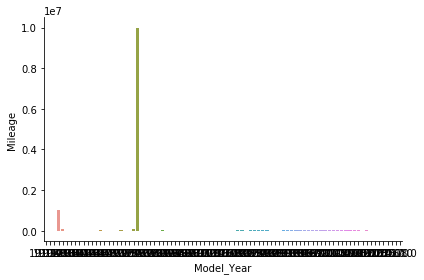

In [172]:
lessT = medianData[medianData['Mileage']<1000000000]
sns.barplot(x=lessT['Model_Year'], y=lessT['Mileage'], data=lessT)
sns.despine()
plt.tight_layout()

# lessT = data[data['Mileage']<100000] #взяли mile<100 000, чтобы можно было посмотреть, на большом масштабе не виждно
# sns.barplot(x=lessT['Model_Year'], y=lessT['Mileage'], data=lessT)
# sns.despine()
# plt.tight_layout()




## Condition

In [173]:
#===Condition
# Used = 1
# New = 0
data['Condition'] = data['Condition'].map({'Used': 1, 'New': 0})

## Buy_Now

In [174]:
#===Buy_Now
# True = 1
# False = 0
print(data['Buy_Now'].value_counts())
data['Buy_Now'] = data['Buy_Now'].map({True: 1.0, False: 0})



#Почему все нан

True     4025
False    3464
Name: Buy_Now, dtype: int64


In [155]:
data['Auction']

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18      False
19       True
20      False
21       True
22       True
23       True
24      False
25       True
26      False
27      False
28       True
29      False
        ...  
7463    False
7464    False
7465    False
7466    False
7467    False
7468    False
7469    False
7470    False
7471    False
7472    False
7473    False
7474    False
7475    False
7476    False
7477    False
7478    False
7479    False
7480    False
7481    False
7482    False
7483    False
7484    False
7485    False
7486    False
7487    False
7488    False
7489    False
7490    False
7491    False
7492    False
Name: Auction, Length: 7489, dtype: bool

## Заполняем пустые строки нулями у некоторых столбцов


In [175]:
data['Condition_Desc'] = data['Condition_Desc'].fillna('no')
data['Location'] = data['Location'].fillna('no')
data['Warranty'] = data['Warranty'].fillna('no')
data['Sub_Model'] = data['Sub_Model'].fillna('no')
data['Type'] = data['Type'].fillna('no')
data['Watch_Count'] = data['Watch_Count'].fillna(0)


# Нижние категории были до этого удалены
data['Vehicle_Title'] = data['Vehicle_Title'].fillna('no')

data['Auction'] = data['Auction'].fillna(False)
data['Auction'] = data['Auction'].map({False: 0, True: 1})



# data['Feedback_Perc'] = data['Feedback_Perc'].fillna(0)
# data['Feedback_Perc'] = data['Feedback_Perc'].map(cleanSybols).astype(int)
# data['Feedback_Perc'] = data['Feedback_Perc'].map(cleanSybols).astype(int)



data['Bid_Count'] = data['Bid_Count'].fillna(0)



#вохможно стоить вместо no другие варианты. 

### Mileage

In [157]:
#1. заполняем найденными медианами нули и минусы
# 2. Заполняем первые 50 лет максимумом из мединаы (999999)
# 3. Заполняем средним по столбцу 

In [176]:

# display(data.Mileage[data['Mileage']<=0].value_counts())

allMilesUnder = data.Mileage[data['Mileage']<=0]
# print(allMilesUnder)

# print(medianData[medianData.index == 39])

for mile in allMilesUnder.index:
    year = data.loc[mile,'Model_Year']
#     print("year - index: ", year, mile)
    medianMileageByYEAR = medianData.Mileage[medianData.Model_Year == year]
#     print(" medianMileageByYEAR: ", medianMileageByYEAR.values)
    data.loc[mile, 'Mileage'] = medianMileageByYEAR.values[0]
#     print(" ", data.loc[mile, 'Model_Year'])


##### Если медиаана и исходные данные пустые, подумать как можно заменить.

data.Mileage[data['Mileage']==-1]=0
data.Mileage[data['Mileage']>=100000]=100000
print(data.Mileage[data['Mileage']<0].value_counts())

C:\Users\timurlan.turataliev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\timurlan.turataliev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Series([], Name: Mileage, dtype: int64)


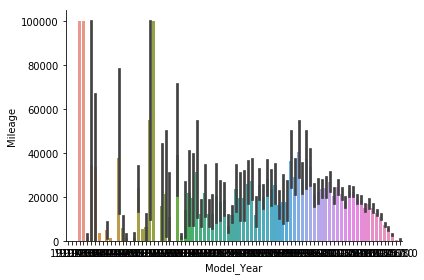

In [177]:
lessT = data[data['Mileage']<=1000000000]
sns.barplot(x=lessT['Model_Year'], y=lessT['Mileage'], data=lessT)
sns.despine()
plt.tight_layout()

# data.Mileage

In [18]:
print(data.Mileage[data['Mileage']<=0])
# print(data.Model_Year[data['Mileage'].index == 2829], medianData.Mileage[medianData['Model_Year']==1956.0] )

2829    0.0
3221    0.0
3319    0.0
3468    0.0
3564    0.0
3565    0.0
3616    0.0
3930    0.0
4769    0.0
4978    0.0
5228    0.0
5285    0.0
5608    0.0
5762    0.0
6066    0.0
6208    0.0
6327    0.0
6354    0.0
6997    0.0
7018    0.0
7073    0.0
7080    0.0
7140    0.0
7142    0.0
7158    0.0
7166    0.0
7167    0.0
7179    0.0
7193    0.0
7200    0.0
7261    0.0
7316    0.0
Name: Mileage, dtype: float64


In [178]:
allMilesUnder = data.Mileage[data['Mileage']<=1]

for mile in allMilesUnder.index:
    meanMile = data.Mileage.loc[mile-10:mile+10].mean()
    data.loc[mile, 'Mileage'] = meanMile
#     print(data.Mileage.loc[mile-10:mile+10])
#     print(mile, meanMile)


### Vehicle_Tile

In [179]:
print(data['Vehicle_Tile'].value_counts())
print(data.Vehicle_Tile[data['Vehicle_Tile'].isnull()].count())
data['Vehicle_Tile'] = data['Vehicle_Tile'].map({'Clear': 1, 'Salvage': 2, 'Rebuilt, Rebuildable &amp; Reconstructed':3, 'Flood, Water Damage':4})

print(data['Vehicle_Tile'].value_counts())

Clear                                       7159
Salvage                                      167
Rebuilt, Rebuildable &amp; Reconstructed     111
Flood, Water Damage                            2
Name: Vehicle_Tile, dtype: int64
0
1.0    7159
2.0     167
3.0     111
4.0       2
Name: Vehicle_Tile, dtype: int64


In [180]:


#Заполняем все nan
data['Vehicle_Tile'] = data['Vehicle_Tile'].fillna(0)
# data['Vehicle_Tile'] = data['Vehicle_Tile'].map({'no': 0})


In [120]:
print(data['Vehicle_Tile'].value_counts())
# print(data['Vehicle_Tile'])
print(data.Vehicle_Tile[data.Vehicle_Tile.isnull()])

1.0    7159
2.0     167
3.0     111
0.0      50
4.0       2
Name: Vehicle_Tile, dtype: int64
Series([], Name: Vehicle_Tile, dtype: float64)


### Seller status

In [181]:
#строки равные нулю заолняем медианой от ['Condition', 'Buy_Now']

# print(data.groupby(['Condition', 'Buy_Now'])['Seller_Status'].aggregate('median'))
medianConditionBuy = data.groupby(['Condition', 'Buy_Now'])['Seller_Status'].aggregate('median')
# print(medianConditionBuy)
medianCB=pd.DataFrame(medianConditionBuy)

medianCB  = medianCB.reset_index()
print(medianCB)
print(medianCB['Condition'])

   Condition  Buy_Now  Seller_Status
0          0      0.0              1
1          0      1.0              1
2          1      0.0              1
3          1      1.0              3
0    0
1    0
2    1
3    1
Name: Condition, dtype: int64


In [182]:
print(data.Seller_Status.value_counts())

allIndex = data.Seller_Status[data['Seller_Status']==0]

for mile in allIndex.index:
#     print(data.loc[mile, 'Seller_Status'])
    cond = data.loc[mile,'Condition']
    buy = data.loc[mile,'Buy_Now']
    
#     print(mile, cond, buy)
    ttt= medianCB.Condition[medianCB.Buy_Now == buy]
    ttt = pd.DataFrame(ttt)    
    tt = ttt[ttt.Condition == cond] 
    med = medianCB.Seller_Status[tt.index[0]]
#     print("\n", med)
    data.loc[mile, 'Seller_Status'] = med
#     print(data.loc[mile, 'Seller_Status'])


1    3766
3    2899
0     628
2     196
Name: Seller_Status, dtype: int64


### Model

In [183]:
# Посмотрим на зависимость модели от model_year
print(data.Model[data.Model.isnull()])
data.Model[data.Model.isnull()] = 'none'
medianMD = data.groupby(['Model'])['Model_Year'].aggregate('median')
medianMD = pd.DataFrame({'Model':medianMD.index, 'Model_Year':medianMD.values})
print(medianMD)


allMDs = data.Model[data.Model=='none']

for md in allMDs.index:
#     print("\n", data.loc[md,'Model'])
    mdy = data.loc[md,'Model_Year']
    medianMdy = medianMD.Model[medianMD.Model_Year == mdy]
    data.loc[md, 'Model'] = medianMdy.values[0]
#     print(data.loc[md,'Model'])





696     NaN
791     NaN
1448    NaN
1556    NaN
1845    NaN
1986    NaN
2050    NaN
2065    NaN
2131    NaN
2677    NaN
2739    NaN
2753    NaN
2829    NaN
2958    NaN
3221    NaN
3319    NaN
3919    NaN
3978    NaN
4327    NaN
4405    NaN
4430    NaN
4454    NaN
4481    NaN
4521    NaN
4619    NaN
4692    NaN
4747    NaN
4768    NaN
4783    NaN
4865    NaN
4951    NaN
4993    NaN
5003    NaN
5077    NaN
5193    NaN
5231    NaN
5238    NaN
5244    NaN
5882    NaN
5914    NaN
5951    NaN
5957    NaN
5977    NaN
6005    NaN
6054    NaN
6169    NaN
6178    NaN
6187    NaN
6418    NaN
6478    NaN
6525    NaN
6901    NaN
7320    NaN
7321    NaN
7322    NaN
Name: Model, dtype: object


C:\Users\timurlan.turataliev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                                            Model  Model_Year
0                  &#039;Retro&#039; Model &#039;      2007.0
1                                   007 dirt bike      2017.0
2                                        1100 EVO      2013.0
3                                      1100 Sport      1996.0
4                                         1125 CR      2009.0
5                                           1125R      2009.0
6                                  1190 ADVENTURE      2014.0
7                                       1190 RC8R      2013.0
8                               1199 Superleggera      2014.0
9                                  1200 Nightster      2008.0
10                                       125 RR-S      2017.0
11                                        1250 FA      2011.0
12                             1290 SUPER DUKE GT      2017.0
13                              1290 Super Duke R      2015.0
14                                  1299 Panigale      2017.0
15      

IndexError: index 0 is out of bounds for axis 0 with size 0

### Extrior_Color

In [184]:
data['Exterior_Color'].fillna('None',inplace=True)
data.Exterior_Color.isnull().count()

7489

### Watch_Count

In [185]:
def cleanSybols(x):
    print(x)
    x = str(x)
    return re.sub('[>,<]', '', x)

In [187]:
data['Watch_Count'] = data['Watch_Count'].map(cleanSybols).astype(int)

# data.Watch_Count.value_counts()
print(data['Watch_Count'])

0
17
0
0
13
0
0
0
16
0
0
0
0
0
0
0
0
0
8
23
0
0
0
0
15
0
25
22
0
31
1
0
12
8
0
0
0
0
0
0
5
2
14
0
4
9
0
4
8
7
16
4
9
18
0
24
5
7
5
0
4
4
0
5
14
5
0
9
2
2
6
2
2
0
3
0
6
2
0
6
0
0
3
3
5
0
5
0
0
9
7
2
10
0
0
1
16
0
0
17
6
2
18
0
14
0
1
0
5
5
8
1
1
0
41
4
0
0
0
0
0
4
11
8
11
4
3
47
9
21
2
0
6
0
0
0
15
0
8
4
31
8
0
19
0
6
0
0
34
0
0
0
31
0
3
8
0
19
10
8
0
2
0
0
7
0
0
1
0
0
4
0
0
9
0
0
3
0
0
0
13
24
0
0
0
27
14
7
12
11
26
11
17
18
0
0
0
3
42
7
0
0
5
42
0
7
0
0
3
16
0
0
9
7
0
13
10
0
0
0
9
4
18
0
11
0
8
26
14
19
0
22
0
0
0
5
0
9
7
15
10
18
8
0
12
12
0
17
12
0
10
0
4
0
2
5
8
11
0
0
0
17
0
7
14
7
17
5
9
22
0
7
4
19
71
7
15
6
41
15
0
18
4
4
0
15
5
0
31
98
6
0
0
1
7
10
8
11
0
0
0
24
29
0
6
27
11
0
7
0
7
5
8
12
0
16
14
11
19
3
6
0
0
6
11
0
0
26
10
1
0
10
0
11
10
3
0
31
11
0
6
0
0
0
3
9
12
10
0
6
31
11
0
6
0
0
24
0
0
3
9
12
0
0
2
11
43
0
6
0
3
2
17
0
0
12
7
0
0
4
0
3
7
0
0
2
1
7
0
5
0
10
0
5
0
21
27
4
0
6
2
33
0
5
21
1
7
13
6
4
7
0
20
12
6
0
49
3
0
6
0
5
0
7
0
13
0
19
1
89
9
0
3
5
10
5
13
53
0
10
2

In [188]:
data['OBO'] = data['OBO'].map({True: 1.0, False: 0})
data['OBO']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      1.0
19      0.0
20      1.0
21      0.0
22      0.0
23      0.0
24      1.0
25      0.0
26      0.0
27      1.0
28      0.0
29      1.0
       ... 
7463    1.0
7464    1.0
7465    1.0
7466    1.0
7467    1.0
7468    1.0
7469    0.0
7470    1.0
7471    1.0
7472    1.0
7473    1.0
7474    1.0
7475    1.0
7476    1.0
7477    1.0
7478    1.0
7479    1.0
7480    1.0
7481    1.0
7482    1.0
7483    1.0
7484    1.0
7485    1.0
7486    1.0
7487    1.0
7488    1.0
7489    1.0
7490    1.0
7491    1.0
7492    0.0
Name: OBO, Length: 7489, dtype: float64

In [ ]:
# data.drop(['Vehicle_Tile'], axis=1, inplace=True)
#Надо выяснить почему становвитс NAN

In [189]:

pd.isnull(data).sum() > 0

Condition         False
Condition_Desc    False
Location          False
Model_Year        False
Mileage           False
Exterior_Color    False
Make              False
Warranty          False
Model             False
Sub_Model         False
Type              False
Vehicle_Title     False
OBO               False
Watch_Count       False
N_Reviews         False
Seller_Status     False
Vehicle_Tile      False
Auction           False
Buy_Now           False
Bid_Count         False
dtype: bool

# Training

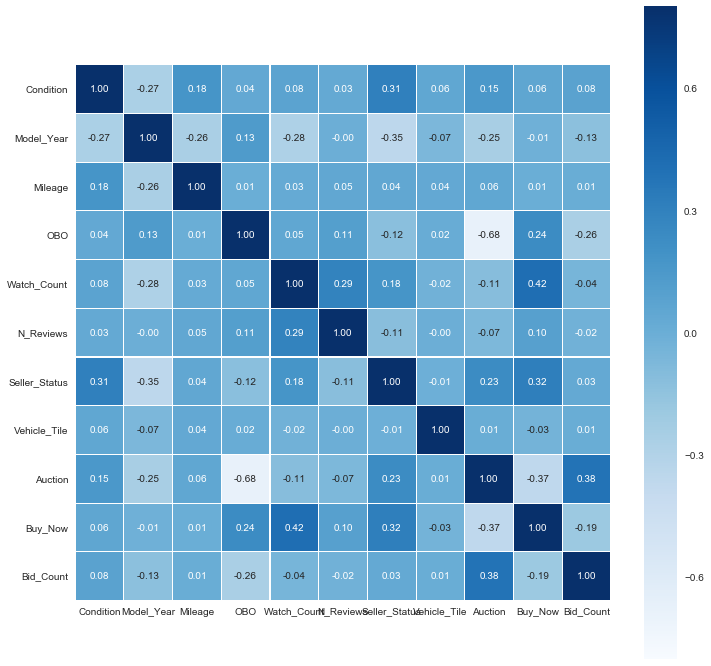

In [32]:
# 1. Корреляция 
colormap = 'Blues'
cor = data.corr()
# cor = cor.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

# генерация признаков

Основные изменения в коде должны произойти в этом блоке.

**Краткое напоминание** :

0. Числовые признаки
    - для линейных моделей признаки стоит масштабировать
1. Категориальные признаки
    - для линейных моделей лучше сделать one-hot-encoding
    - для деревьев лучше сделать LabelEncoding
    - для категориальных признаков высокой размерности (>10) можно сделать кодирование средним значением таргета. Это облегчит работу и для деревьев, и для линейных моделей
2. Время и координаты
    - оба типа признаков обладают некоторым внутренним порядком (два момента времени можно сравнить, широту/долготу тоже)
    - оба типа признаков позволяют посчитать расстояния между объектами

In [190]:

# Spilt numeric and categorical features
cat_feats = data.select_dtypes(include=['object']).columns
num_feats = data.select_dtypes(include=['float64','int64', 'bool', 'int32']).columns
num_df = data[num_feats]
cat_df = data[cat_feats]
print('There are %d numeric features and %d categorical features\n' %(len(num_feats),len(cat_feats)))
print('Numeric features:\n',num_feats.values)
print('Categorical features:\n',cat_feats.values)

There are 11 numeric features and 9 categorical features

Numeric features:
 ['Condition' 'Model_Year' 'Mileage' 'OBO' 'Watch_Count' 'N_Reviews'
 'Seller_Status' 'Vehicle_Tile' 'Auction' 'Buy_Now' 'Bid_Count']
Categorical features:
 ['Condition_Desc' 'Location' 'Exterior_Color' 'Make' 'Warranty' 'Model'
 'Sub_Model' 'Type' 'Vehicle_Title']


In [191]:
# One hot encoding
one_hot_data = pd.get_dummies(cat_df)

#label encoding
label_encoder = LabelEncoder()
for column in cat_feats.values:
    print(column)
    data[column] = label_encoder.fit_transform(data[column])

# label_encode_data.value_counts().plot.barh()

# Merge all features
new_data_onehot = pd.concat([num_df,one_hot_data],axis=1)




Condition_Desc
Location
Exterior_Color
Make
Warranty
Model
Sub_Model
Type
Vehicle_Title


In [35]:
new_data_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7489 entries, 0 to 7492
Columns: 7407 entries, Condition to Vehicle_Title_no
dtypes: float64(6), int64(5), uint8(7396)
memory usage: 53.8 MB


In [ ]:
xcols = [c for c in new_data if c != target]
print(xcols)

# валидация

In [192]:


X = data.select_dtypes(['int32', 'int64', 'float32', 'float64', 'bool'])


# X = new_data[xcols].select_dtypes(['int32', 'int64', 'float32', 'float64', 'bool'])
X = X.fillna(0)
X.info()

X_train = X.loc[itr]
X_test  = X.loc[ite]


##### for Linear Models from ONE HOt

X_onehot = new_data_onehot.select_dtypes(['int32', 'int64', 'float32', 'float64', 'uint8'])

# X = new_data[xcols].select_dtypes(['int32', 'int64', 'float32', 'float64', 'bool'])
X_onehot = X_onehot.fillna(0)

X_train_onehot = X_onehot.loc[itr]
X_test_onehot  = X_onehot.loc[ite]



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7489 entries, 0 to 7492
Data columns (total 20 columns):
Condition         7489 non-null int64
Condition_Desc    7489 non-null int64
Location          7489 non-null int64
Model_Year        7489 non-null float64
Mileage           7489 non-null float64
Exterior_Color    7489 non-null int64
Make              7489 non-null int64
Warranty          7489 non-null int64
Model             7489 non-null int64
Sub_Model         7489 non-null int64
Type              7489 non-null int64
Vehicle_Title     7489 non-null int64
OBO               7489 non-null float64
Watch_Count       7489 non-null int32
N_Reviews         7489 non-null int64
Seller_Status     7489 non-null int64
Vehicle_Tile      7489 non-null float64
Auction           7489 non-null int64
Buy_Now           7489 non-null float64
Bid_Count         7489 non-null float64
dtypes: float64(6), int32(1), int64(13)
memory usage: 1.5 MB


In [191]:
# pd.isnull(X.loc[itr]).sum() > 0
# display(X.loc[itr].head(5))
# X.loc[ite].head(5)

# X_train.replace([np.inf, -np.inf], np.nan)
X_train[X_train.isnull()].count()
X_train

,Condition,Condition_Desc,Location,Model_Year,Mileage,Exterior_Color,Make,Warranty,Model,Sub_Model,Type,Vehicle_Title,OBO,Watch_Count,N_Reviews,Seller_Status,Vehicle_Tile,Auction,Buy_Now,Bid_Count
0,1.0,1131.0,1070.0,2013.0,16000.0,102.0,28.0,56.0,1387.0,1186.0,43.0,0.0,0.0,0.0,2427.0,3.0,1.0,1.0,0.0,28.0
2,1.0,1137.0,306.0,1970.0,25763.0,687.0,7.0,57.0,978.0,738.0,165.0,0.0,0.0,0.0,136.0,1.0,1.0,1.0,0.0,26.0
3,1.0,231.0,681.0,2009.0,33142.0,614.0,28.0,68.0,1387.0,1195.0,185.0,0.0,0.0,0.0,2920.0,1.0,1.0,1.0,0.0,11.0
5,1.0,517.0,1893.0,1972.0,8685.0,614.0,28.0,57.0,1234.0,1155.0,216.0,0.0,0.0,0.0,412.0,3.0,1.0,1.0,0.0,1.0
7,1.0,1137.0,1961.0,1975.0,17868.0,102.0,28.0,57.0,1234.0,1066.0,163.0,0.0,0.0,0.0,1159.0,3.0,1.0,1.0,0.0,6.0
10,1.0,1137.0,1961.0,1978.0,30.0,222.0,28.0,57.0,1387.0,639.0,43.0,0.0,0.0,0.0,1159.0,3.0,1.0,1.0,0.0,4.0
11,1.0,1137.0,1278.0,2011.0,5800.0,102.0,28.0,57.0,1387.0,901.0,185.0,0.0,0.0,0.0,83.0,3.0,1.0,1.0,0.0,21.0
13,1.0,686.0,1017.0,2000.0,57898.0,474.0,28.0,58.0,1387.0,1155.0,43.0,0.0,0.0,0.0,10701.0,1.0,1.0,1.0,0.0,2.0
16,1.0,1137.0,665.0,1973.0,9305.0,762.0,28.0,57.0,942.0,864.0,190.0,0.0,0.0,0.0,300.0,3.0,1.0,1.0,0.0,25.0
17,1.0,90.0,1410.0,2016.0,1125.0,180.0,28.0,59.0,1206.0,564.0,43.0,0.0,0.0,0.0,170.0,3.0,1.0,1.0,0.0,0.0


In [193]:
X_train = X_train.astype('float32')

X_train = X_train.fillna(0)
y_train = np.nan_to_num(y_train)

print(X_train)

      Condition  Condition_Desc  Location  Model_Year   Mileage  \
0           1.0          1131.0    1070.0      2013.0   16000.0   
2           1.0          1137.0     306.0      1970.0   25763.0   
3           1.0           231.0     681.0      2009.0   33142.0   
5           1.0           517.0    1893.0      1972.0    8685.0   
7           1.0          1137.0    1961.0      1975.0   17868.0   
10          1.0          1137.0    1961.0      1978.0      30.0   
11          1.0          1137.0    1278.0      2011.0    5800.0   
13          1.0           686.0    1017.0      2000.0   57898.0   
16          1.0          1137.0     665.0      1973.0    9305.0   
17          1.0            90.0    1410.0      2016.0    1125.0   
19          0.0          1137.0     444.0      2016.0     250.0   
21          1.0           480.0    1312.0      2005.0   25405.0   
22          1.0          1137.0     393.0      1982.0   28888.0   
23          1.0          1137.0    1893.0      2001.0   23658.

[4995 rows x 20 columns]


In [ ]:
print(len(itr), len(ite), len(X_train), len(y_train))
# print(pd.DataFrame(y_train).isnull().sum()>0)
# print(pd.isnull(y_train))
# print(X_train[X_train.isnull()].sum()>0)
# print(X_train)
X_train.replace((np.inf, -np.inf), 0)
np.nan_to_num(y_train)

# X_train[X_train.Buy_Now == -np.inf]

In [89]:
def rmse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2) ** 0.5

## Random Forest

In [193]:

model = RandomForestRegressor()
# model = Ridge()

score_mse = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error')
score_rmse = score_mse ** 0.5
print(np.mean(score_rmse))

6903.92740233


In [194]:
model.fit(X_train, y_train)
X_test = X_test.fillna(0)

y_pred = model.predict(X_test)

rmse(y_test, y_pred)

5652.4427238116559

In [39]:
# Optimize

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)



{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

print("Best params: ", rf_random.best_params_)

y_pred = rf_random.best_params_.predict(X_test)

rmse(y_test, y_pred)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  12.6s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  12.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


## LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression

X_train_onehot = X_train_onehot.fillna(0)
y_train = np.nan_to_num(y_train)

# np.sqrt(-cross_val_score(LogisticRegression(),X_train_onehot, y_train, cv=3, scoring='neg_mean_squared_error').mean())

/Users/Timur/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


7079.4289237126814

In [38]:
model_logistic = LogisticRegression()
# model = Ridge()

score_mse_logistic = -cross_val_score(model_logistic, X_train_onehot, y_train, scoring='neg_mean_squared_error')
score_rmse = score_mse_logistic ** 0.5
print(np.mean(score_rmse))


model_logistic.fit(X_train_onehot, y_train)
X_test_onehot = X_test_onehot.fillna(0)

y_pred = model_logistic.predict(X_test_onehot)

rmse(y_test, y_pred)

/Users/Timur/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


7039.80939038


7286.2461646129595

In [ ]:
X_scaled_train = preprocessing.scale(X_train)
X_scaled_test = preprocessing.scale(X_test)

X_normalized_train = preprocessing.Normalizer().fit(X_train)
X_normalized_test = preprocessing.Normalizer().fit(X_test)

# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

In [ ]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import uniform as sp_rand

# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(X_train, y_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.rmse)
print(rsearch.best_estimator_.alpha)

## XGBoost

In [36]:
import xgboost as xgb

np.sqrt(-cross_val_score(xgb.XGBRegressor(),X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean())

6450.9226401033366

In [42]:
print(X_train)
y_train

      Condition  Condition_Desc  Location  Model_Year   Mileage  \
0           1.0          1131.0    1070.0      2013.0   16000.0   
2           1.0          1137.0     306.0      1970.0   25763.0   
3           1.0           231.0     681.0      2009.0   33142.0   
5           1.0           517.0    1893.0      1972.0    8685.0   
7           1.0          1137.0    1961.0      1975.0   17868.0   
10          1.0          1137.0    1961.0      1978.0      30.0   
11          1.0          1137.0    1278.0      2011.0    5800.0   
13          1.0           686.0    1017.0      2000.0   57898.0   
16          1.0          1137.0     665.0      1973.0    9305.0   
17          1.0            90.0    1410.0      2016.0    1125.0   
19          0.0          1137.0     444.0      2016.0     250.0   
21          1.0           480.0    1312.0      2005.0   25405.0   
22          1.0          1137.0     393.0      1982.0   28888.0   
23          1.0          1137.0    1893.0      2001.0   23658.

array([11412,  3872,  6575, ...,  8900,  4900,  7800])

In [37]:
model = xgb.XGBRegressor()
# model = Ridge()

score_mse = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error')
score_rmse = score_mse ** 0.5
print(np.mean(score_rmse))


model.fit(X_train, y_train)
X_test = X_test.fillna(0)

y_pred = model.predict(X_test)


rmse(y_test, y_pred)

6449.86411335


5910.224801674698

# проверка на тестовых данных
rmse на тестовой выборке должно получиться меньше 5000

In [94]:

(data.columns)

Index(['Condition', 'Condition_Desc', 'Location', 'Model_Year', 'Mileage',
       'Exterior_Color', 'Make', 'Warranty', 'Model', 'Sub_Model', 'Type',
       'Vehicle_Title', 'OBO', 'Watch_Count', 'N_Reviews', 'Seller_Status',
       'Vehicle_Tile', 'Auction', 'Buy_Now', 'Bid_Count'],
      dtype='object')

In [194]:
## Using H2O lib
import h2o
from h2o.automl import H2OAutoML

In [195]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\Users\timurlan.turataliev\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\TIMURL~1.TUR\AppData\Local\Temp\tmp_rsdr4ut
  JVM stdout: C:\Users\TIMURL~1.TUR\AppData\Local\Temp\tmp_rsdr4ut\h2o_Timurlan_Turataliev_started_from_python.out
  JVM stderr: C:\Users\TIMURL~1.TUR\AppData\Local\Temp\tmp_rsdr4ut\h2o_Timurlan_Turataliev_started_from_python.err
  Server is running at http://127.0.0.1:54325
Connecting to H2O server at http://127.0.0.1:54325... successful.


H2O cluster uptime:,08 secs
H2O cluster timezone:,Europe/Moscow
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.1
H2O cluster version age:,27 days
H2O cluster name:,H2O_from_python_Timurlan_Turataliev_kvw651
H2O cluster total nodes:,1
H2O cluster free memory:,1.752 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [196]:
# print(y_train)

# print(pd.concat([X_train, pd.DataFrame(y_train)],axis=1))
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

h2o_train = pd.concat([X_train, pd.DataFrame(y_train)],axis=1)
h2o_train=h2o_train.rename(index=str, columns={0: "Price"})
# h2o_train['OBO'] = h2o_train['OBO'].map({True: 1.0, False: 0})

h2o_test = pd.concat([X_test, pd.DataFrame(y_test)],axis=1)
h2o_test=h2o_test.rename(index=str, columns={0: "Price"})
# h2o_test['OBO'] = h2o_test['OBO'].map({True: 1.0, False: 0})


In [197]:
h2o_tr_converted = h2o.H2OFrame(h2o_train, column_names = ['Condition', 'Condition_Desc', 'Location', 'Model_Year', 'Mileage',
       'Exterior_Color', 'Make', 'Warranty', 'Model', 'Sub_Model', 'Type',
       'Vehicle_Title', 'OBO', 'Watch_Count', 'N_Reviews', 'Seller_Status',
       'Vehicle_Tile', 'Auction', 'Buy_Now', 'Bid_Count', 'Price'])

h2o_te_converted = h2o.H2OFrame(h2o_test,column_names = ['Condition', 'Condition_Desc', 'Location', 'Model_Year', 'Mileage',
       'Exterior_Color', 'Make', 'Warranty', 'Model', 'Sub_Model', 'Type',
       'Vehicle_Title', 'OBO', 'Watch_Count', 'N_Reviews', 'Seller_Status',
       'Vehicle_Tile', 'Auction', 'Buy_Now', 'Bid_Count', 'Price'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [96]:
print(h2o_te_converted)

Condition,Condition_Desc,Location,Model_Year,Mileage,Exterior_Color,Make,Warranty,Model,Sub_Model,Type,Vehicle_Title,OBO,Watch_Count,N_Reviews,Seller_Status,Vehicle_Tile,Auction,Buy_Now,Bid_Count,Price
1,698,584,2016,60,102,28,59,1387,901,159,0,0,17,657,3,1,1,1,0,17200
1,1137,1915,2012,17800,180,28,35,1387,833,185,0,0,13,271,2,1,1,1,0,10000
1,1137,1714,2010,5548,427,28,68,1387,497,185,0,0,0,6229,1,1,1,0,1,24900
1,1137,1337,2014,2800,291,28,57,1387,1155,185,0,0,16,3,3,1,1,1,6,5100
1,1137,306,2015,3000,102,28,59,1234,492,43,0,0,0,1,3,1,1,0,0,8000
1,1137,1383,2002,55000,609,28,57,942,671,185,0,0,0,128,3,1,1,0,5,1125
1,1137,412,2008,22102,545,28,57,1387,1155,185,0,0,0,244,3,1,1,0,16,5500
1,1137,1420,2010,7792,614,28,57,1387,422,185,0,0,0,299,3,1,1,0,3,9000
1,1137,137,2015,5500,614,28,59,1387,967,185,0,1,8,66,3,1,0,1,0,20000
0,1137,1320,2017,140,102,28,59,1387,1155,156,0,1,0,3172,3,1,0,1,0,10900


In [208]:

aml = H2OAutoML(max_runtime_secs = 600)
aml.train(x = ['Condition', 'Condition_Desc', 'Location', 'Model_Year', 'Mileage',
       'Exterior_Color', 'Make', 'Warranty', 'Model', 'Sub_Model', 'Type',
       'Vehicle_Title', 'OBO', 'Watch_Count', 'N_Reviews', 'Seller_Status',
       'Vehicle_Tile', 'Auction', 'Buy_Now', 'Bid_Count', 'Price'], y = target,
          training_frame = h2o_tr_converted,
          leaderboard_frame = h2o_te_converted)

# View the AutoML Leaderboard
lb = aml.leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [209]:
lb

model_id,mean_residual_deviance,rmse,mae,rmsle
StackedEnsemble_AllModels_0_AutoML_20180312_152315,"26525469,024918","5150,288247","2795,957967",NaN
StackedEnsemble_AllModels_0_AutoML_20180312_145727,"27137914,312546","5209,406330","2858,483205",NaN
StackedEnsemble_AllModels_0_AutoML_20180312_145445,"27198830,082400","5215,249762","2868,606120",NaN
StackedEnsemble_AllModels_0_AutoML_20180312_114536,"27245968,768043","5219,767118","2884,622625",NaN
GBM_grid_0_AutoML_20180312_152315_model_29,"28061585,133528","5297,318674","2880,225808","0,815447"
GBM_grid_0_AutoML_20180312_152315_model_47,"28079867,656255","5299,044032","2950,810970","0,832203"
GBM_grid_0_AutoML_20180312_152315_model_13,"28255397,477770","5315,580634","2940,429240",NaN
GBM_grid_0_AutoML_20180312_152315_model_48,"28576578,170616","5345,706517","3063,073722",NaN
GBM_grid_0_AutoML_20180312_114536_model_34,"28727817,409424","5359,833711","2937,487943",NaN
StackedEnsemble_BestOfFamily_0_AutoML_20180312_114536,"28747197,624785","5361,641318","3068,641465","0,879570"


In [199]:
lb

model_id,mean_residual_deviance,rmse,mae,rmsle
StackedEnsemble_AllModels_0_AutoML_20180312_114536,"27245968,768043","5219,767118","2884,622625",NaN
GBM_grid_0_AutoML_20180312_114536_model_34,"28727817,409424","5359,833711","2937,487943",NaN
StackedEnsemble_BestOfFamily_0_AutoML_20180312_114536,"28747197,624785","5361,641318","3068,641465","0,879570"
GBM_grid_0_AutoML_20180312_114536_model_29,"29076233,280877","5392,238244","3098,780835",NaN
GBM_grid_0_AutoML_20180312_114536_model_2,"29099436,316087","5394,389337","3047,538783",NaN
GBM_grid_0_AutoML_20180312_114536_model_3,"29126385,920132","5396,886688","3012,304769",NaN
GBM_grid_0_AutoML_20180312_114536_model_22,"29156637,408786","5399,688640","3065,646671",NaN
GBM_grid_0_AutoML_20180312_114536_model_12,"29272176,603533","5410,376752","3149,080987","0,892941"
GBM_grid_0_AutoML_20180312_114536_model_6,"29455545,244838","5427,296311","3133,510755","0,885045"
GBM_grid_0_AutoML_20180312_114536_model_0,"29530299,988223","5434,178870","3125,210442","0,857141"


In [63]:
# y_test

h2o_y_test = h2o.H2OFrame(y_test, column_names = ['Price'])
h2o_y_test


Price
17200
10000
24900
5100
8000
1125
5500
9000
20000
10900


In [60]:
preds = aml.leader.predict(h2o_y_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


/Users/Timur/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'Condition': substituting in a column of NaN
  warnings.warn(w)
/Users/Timur/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'Model_Year': substituting in a column of NaN
  warnings.warn(w)
/Users/Timur/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'Mileage': substituting in a column of NaN
  warnings.warn(w)
/Users/Timur/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'OBO': substituting in a column of NaN
  warnings.warn(w)
/Users/Timur/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'Watch_Count': substituting in a column of NaN
  warnings.warn(w)
/Users/Timur/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: T

In [61]:
preds.head()


predict
8001.94
8001.94
8001.94
8001.94
8001.94
8001.94
8001.94
8001.94
8001.94
8001.94


In [62]:
perf = aml.leader.model_performance(h2o_te_converted)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 44387948.02748606
RMSE: 6662.428087978591
MAE: 4291.0668743373
RMSLE: 0.9928705949030111
R^2: 0.3900999505157813
Mean Residual Deviance: 44387948.02748606
Null degrees of freedom: 2497
Residual degrees of freedom: 2467
Null deviance: 181858658907.33963
Residual deviance: 110881094172.66019
AIC: 51138.99632912443


In [210]:
# Save best model
model_path = h2o.save_model(model = aml.leader, path = "h2o_best", force=True)
print(model_path)

# load
# saved_model = h2o_load_model(model_path)

C:\Users\timurlan.turataliev\Desktop\Courses\EYML Courses\ey_courses\hw10\h2o_best\StackedEnsemble_AllModels_0_AutoML_20180312_152315


In [206]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_h2o = H2OGradientBoostingEstimator()
gbm_h2o.train(x = ['Condition', 'Condition_Desc', 'Location', 'Model_Year', 'Mileage',
       'Exterior_Color', 'Make', 'Warranty', 'Model', 'Sub_Model', 'Type',
       'Vehicle_Title', 'OBO', 'Watch_Count', 'N_Reviews', 'Seller_Status',
       'Vehicle_Tile', 'Auction', 'Buy_Now', 'Bid_Count', 'Price'], y = target,
          training_frame = h2o_tr_converted)
print(gbm_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1520844111459_1


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 22819766.239468846
RMSE: 4777.00389778665
MAE: 3094.6493803709714
RMSLE: 0.855171708791136
Mean Residual Deviance: 22819766.239468846
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-03-12 15:08:17,0.221 sec,0.0,8479.2466555,6089.4507242,71897623.8450781
,2018-03-12 15:08:17,0.743 sec,1.0,8134.8357524,5795.0293280,66175552.7183825
,2018-03-12 15:08:18,1.062 sec,2.0,7844.3439733,5543.6951846,61533732.3722005
,2018-03-12 15:08:18,1.271 sec,3.0,7576.1373813,5307.2959340,57397857.6198249
,2018-03-12 15:08:19,2.113 sec,4.0,7331.6151987,5088.2985520,53752581.4223271
,2018-03-12 15:08:19,2.276 sec,5.0,7133.4097188,4910.5759771,50885534.2167614
,2018-03-12 15:08:19,2.290 sec,6.0,6947.3753434,4738.6347945,48266024.1625158
,2018-03-12 15:08:19,2.475 sec,7.0,6757.0895723,4599.1190786,45658259.4882443
,2018-03-12 15:08:19,2.730 sec,8.0,6606.6041164,4463.9148383,43647217.9503979
,2018-03-12 15:08:20,3.056 sec,9.0,6447.4716756,4350.7037905,41569891.0082272


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Model_Year,374428893184.0000000,1.0,0.2902030
Model,260690083840.0000000,0.6962339,0.2020492
Make,242571935744.0000000,0.6478451,0.1880066
Auction,131534225408.0000000,0.3512929,0.1019463
Type,69150040064.0000000,0.1846814,0.0535951
Sub_Model,54380896256.0000000,0.1452369,0.0421482
Bid_Count,31122790400.0000000,0.0831207,0.0241219
Mileage,30447329280.0000000,0.0813167,0.0235984
Location,28359303168.0000000,0.0757402,0.0219800
Watch_Count,15551699968.0000000,0.0415345,0.0120534


In [207]:
gbm_h2o.model_performance(h2o_te_converted)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 32955222.997068234
RMSE: 5740.663985730939
MAE: 3461.178639322244
RMSLE: 0.8975034659977269
Mean Residual Deviance: 32955222.997068234
